In [1]:
import sys
sys.path.append("../") 

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home='../data',cache=True,as_frame=False)
X=X/255.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [4]:
import numpy as np
import mxnet as mx
from mxnet import nd, autograd, gluon
from hamiltonian import utils

N,D=X_train.shape
K=len(np.unique(y_train))

y_train=utils.one_hot(y_train,K)
y_test=utils.one_hot(y_test,K)

model_ctx=mx.gpu()
par={'weights':nd.random_normal(shape=(D,K),ctx=model_ctx),'bias':nd.random_normal(shape=K,ctx=model_ctx)}
hyper={'alpha':nd.array(1.0, ctx=model_ctx)}

In [5]:
from hamiltonian.inference.sgd import sgd
from hamiltonian.models.softmax import softmax

model=softmax(hyper,ctx=model_ctx)
inference=sgd(model,par,ctx=model_ctx)

In [6]:
for param in par:
    par[param].attach_grad()

In [7]:
X_batch=nd.array(X_train[:32,:],ctx=model_ctx)
y_batch=nd.array(y_train[:32,:],ctx=model_ctx)

In [8]:
with autograd.record():
    y_hat = model.forward(par,X_train=X_batch)
    loss = model.cross_entropy(y_hat, y_batch)
loss.backward()

In [20]:
for param in par:
    print(par[param].grad)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<NDArray 784x10 @gpu(0)>

[ 3.6270564e-10  6.9129153e-04 -3.1612293e-05 -1.1184757e-03
  1.5727588e-03  4.6156006e-04 -2.9112927e-03  5.2149704e-04
  6.4088556e-05  7.5018423e-04]
<NDArray 10 @gpu(0)>


In [18]:
grad_p=model.grad(par,X_train=X_batch,y_train=y_batch)

In [19]:
for grad in grad_p:
    print(grad_p[grad])


[[-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 ...
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]
 [-0. -0. -0. ... -0. -0. -0.]]
<NDArray 784x10 @gpu(0)>

[-4.0000000e+00 -1.0236630e-05  4.8620201e-04  1.0071458e+00
  6.2276903e-03  3.0015748e+00  3.3494439e-07  9.8290050e-04
 -4.9934565e-04 -1.5908213e-02]
<NDArray 10 @gpu(0)>


In [15]:
par,loss=inference.fit(epochs=100,batch_size=128,gamma=0.9,X_train=X_train,y_train=y_train,verbose=True)

  1%|          | 1/100 [00:00<01:36,  1.02it/s]

loss: 1.9853


 11%|█         | 11/100 [00:11<01:30,  1.02s/it]

loss: 1.5977


 21%|██        | 21/100 [00:21<01:18,  1.00it/s]

loss: 1.5805


 31%|███       | 31/100 [00:31<01:11,  1.04s/it]

loss: 1.5748


 41%|████      | 41/100 [00:41<01:02,  1.06s/it]

loss: 1.5724


 51%|█████     | 51/100 [00:51<00:47,  1.03it/s]

loss: 1.5701


 61%|██████    | 61/100 [01:01<00:37,  1.03it/s]

loss: 1.5682


 71%|███████   | 71/100 [01:11<00:28,  1.04it/s]

loss: 1.5666


 81%|████████  | 81/100 [01:20<00:18,  1.04it/s]

loss: 1.5649


 91%|█████████ | 91/100 [01:30<00:08,  1.03it/s]

loss: 1.5635


100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


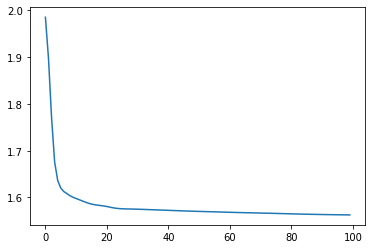

In [16]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.show()

In [22]:
y_pred=model.predict(par,nd.array(X_test,ctx=model_ctx))

In [25]:
y_pred[:10]


[8. 2. 5. 6. 5. 5. 8. 7. 1. 8.]
<NDArray 10 @gpu(0)>

In [24]:
y_test.argmax(a)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])